In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
import joblib

# --- 1. Load and Prepare Data ---
df = pd.read_csv("arecanut.csv")
df['Price Date'] = pd.to_datetime(df['Price Date'])
df.sort_values('Price Date', inplace=True)
price_data = df[['Modal Price (Rs./Quintal)']].values

# --- 2. Scale the Data ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

# --- 3. Create Sequences ---
SEQUENCE_LENGTH = 30
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - SEQUENCE_LENGTH:]

X_train, y_train, X_test, y_test = [], [], [], []

# Training sequences
for i in range(SEQUENCE_LENGTH, len(train_data)):
    X_train.append(train_data[i - SEQUENCE_LENGTH:i, 0])
    y_train.append(train_data[i, 0])

# Testing sequences
for i in range(SEQUENCE_LENGTH, len(test_data)):
    X_test.append(test_data[i - SEQUENCE_LENGTH:i, 0])
    y_test.append(test_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape for RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# --- 4. Build and Train the RNN Model ---
model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    SimpleRNN(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("\nTraining RNN Model")
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=1,
                    validation_data=(X_test, y_test))

# --- 5. Evaluate Model ---
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"\n--- Model Performance ---")
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# --- 6. Save Model, Scaler, and Test Data ---
model.save('model_patora.keras')
joblib.dump(scaler, 'scaler_patora.gz')

print("\n--- Files Saved ---")
print("Model saved as 'model_patora.keras'")
print("Scaler saved as 'scaler_patora.gz'")

Training samples: 2610
Testing samples: 660

Training RNN Model
Epoch 1/100
82/82 [==============================] - 1s 9ms/step - loss: 0.0312 - mae: 0.1240 - val_loss: 0.0043 - val_mae: 0.0289
Epoch 2/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0085 - mae: 0.0706 - val_loss: 0.0041 - val_mae: 0.0358
Epoch 3/100
82/82 [==============================] - 0s 5ms/step - loss: 0.0069 - mae: 0.0631 - val_loss: 0.0048 - val_mae: 0.0512
Epoch 4/100
82/82 [==============================] - 0s 6ms/step - loss: 0.0058 - mae: 0.0576 - val_loss: 0.0058 - val_mae: 0.0573
Epoch 5/100
82/82 [==============================] - 0s 6ms/step - loss: 0.0052 - mae: 0.0541 - val_loss: 0.0042 - val_mae: 0.0410
Epoch 6/100
82/82 [==============================] - 1s 6ms/step - loss: 0.0047 - mae: 0.0516 - val_loss: 0.0054 - val_mae: 0.0536
Epoch 7/100
82/82 [==============================] - 0s 6ms/step - loss: 0.0045 - mae: 0.0498 - val_loss: 0.0037 - val_mae: 0.0388
Epoch 8/100
82/82 [

21/21 [==============================] - 0s 2ms/step


/var/folders/ls/k1p_ptn500g_fx4qdb8780cc0000gp/T/ipykernel_68640/342431941.py:34: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from current font.
  plt.tight_layout()
/Users/adityarao/arecanut_rnn/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


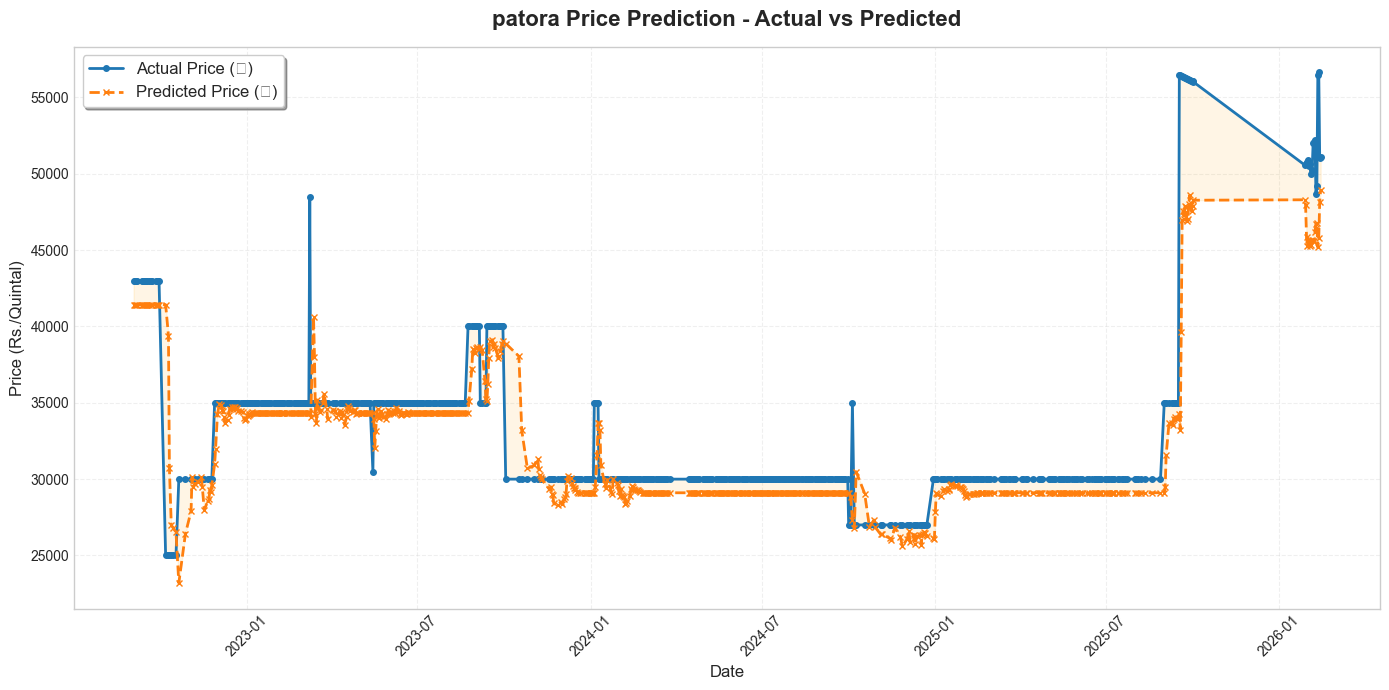


Mean Absolute Error (MAE): 1443.99
R² Score: 0.7941


In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, r2_score
df=pd.read_csv("arecanut.csv")
df['Price Date'] = pd.to_datetime(df['Price Date'])

# --- 2. Predict ---
y_pred = model.predict(X_test)

# --- 3. Inverse Transform ---
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- 4. Get Matching Dates ---
test_dates = df['Price Date'].iloc[-len(y_test_inv):]

# --- 5. Plot Actual vs Predicted ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14,7))

plt.plot(test_dates, y_test_inv, marker='o', markersize=4, color='#1f77b4', linewidth=2, label='Actual Price (₹)')
plt.plot(test_dates, y_pred_inv, marker='x', markersize=4, color='#ff7f0e', linestyle='--', linewidth=2, label='Predicted Price (₹)')
plt.fill_between(test_dates, y_test_inv.ravel(), y_pred_inv.ravel(), color='orange', alpha=0.1)

plt.title('patora Price Prediction - Actual vs Predicted', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (Rs./Quintal)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=True, fontsize=12, loc='best', shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# --- 6. Show Model Performance ---
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")